# Training PIsToN

This notebook is a supplemental material to the paper titled "PIsToN: Evaluating Protein Binding Interfaces with Transformer Networks."

The notebook provides an example on how to train the PIsToN model.
 
If you are using this code, please cite the following paper:

Stebliankin V, Shirali A, Baral P, Chapagain P, Narasimhan G. PIsToN: Evaluating Protein Binding Interfaces with Transformer Networks. bioRxiv. 2023 Jan 4:2023-01.

---
Vitalii Stebliankin (vsteb002@fiu.edu) <br>
Bioinformatics Research Group (BioRG) <br>
Florida International University
---


In [1]:
import numpy as np
import torch
import torch.nn as nn

import random

from torch.utils.data import DataLoader

from tqdm import tqdm
import os

#### Local import
import sys
sys.path.append('../../src')
from utils.dataset import PDB_complex_training
from utils.trainer import fit, evaluate_val
from utils.utils import get_processed

In [2]:
# Description of features:
    # 0 - Shape index | p1
    # 1 - Distance depended curvature | p1
    # 2 - Hydrogen bond potential | p1
    # 3 - Charge | p1
    # 4 - Hydrophobicity | p1
    # 5 - Shape index | p1
    # 6 - Distance depended curvature | p1
    # 7 - Hydrogen bond potential | p1
    # 8 - Charge | p1
    # 9 - Hydrophobicity | p1
    # 10 - Distance between atoms | p1 and p2
    # 11 - Relative ASA | p1
    # 12 - Relative ASA | p2

In [3]:
# Constants and directories
MARGIN=0
TEMP=0.5
DIM=16

DATA_DIR = os.getcwd()+'./data_preparation/'

TRAIN_LIST_FILE = '../data/lists/training.txt'
VAL_LIST_FILE = '../data/lists/final_val.txt'

PATIENCE=10 # number of consequitive times when model don't improve before early stopping
SEED_ID = 7272
BATCH_SIZE=1
MAX_EPOCH = 200

MODEL_NAME=f'PIsToN_multiAttn_contrast'
MODEL_DIR=f'./savedModels/{MODEL_NAME}'
IMG_SIZE=32

# Select only original MaSIF features
FEATURES_SUBSET = list(range(13)) # Use all features
N_FEATURES=len(FEATURES_SUBSET)

## Config

In [4]:
import os

config = {}

config['dirs'] = {}
config['dirs']['data_prepare'] = DATA_DIR
config['dirs']['grid'] = config['dirs']['data_prepare'] + '07-grid/'
config['dirs']['docked'] = config['dirs']['data_prepare'] + 'docked/'
config['dirs']['tmp'] = '/aul/homes/vsteb002/tmp'

config['ppi_const'] = {}
config['ppi_const']['patch_r'] = 16 # 16

os.environ["TMP"] = config['dirs']['tmp']
os.environ["TMPDIR"] = config['dirs']['tmp']
os.environ["TEMP"] = config['dirs']['tmp']

## Get the list of processed complexes

In some cases, a complex can't be pre-processed due to the memory overflow.

In [5]:
from utils.utils import get_processed

train_list = [x.strip('\n') for x in open(TRAIN_LIST_FILE, 'r').readlines()]
val_list = [x.strip('\n') for x in open(VAL_LIST_FILE, 'r').readlines()]

train_list_updated = get_processed(train_list, config)
val_list_updated = get_processed(val_list, config)

print(f"{len(train_list_updated)}/{len(train_list)} training complexes were processed for 12A")
print(f"{len(val_list_updated)}/{len(val_list)} validation complexes were processed for 12A")


4819/4942 training complexes were processed for 12A
179/181 validation complexes were processed for 12A


## Learn mean and standard deviation for standard scaling for images

In [6]:
## Read all positive complexes
grid_native_list = []
for ppi in train_list:
    grid_path = f"{config['dirs']['grid']}/{ppi}.npy"
    if os.path.exists(grid_path):
        grid_native_list.append(np.load(grid_path, allow_pickle=True))

print(f"Loaded {len(grid_native_list)} native complexes")
all_grid = np.stack(grid_native_list, axis=0)

radius = config['ppi_const']['patch_r']


std_array = np.ones(N_FEATURES)
mean_array = np.zeros(N_FEATURES)

feature_pairs = {
    'shape_index': (0, 5),
    'ddc': (1, 6),
    'electrostatics': (2, 7),
    'charge': (3, 8),
    'hydrophobicity': (4, 9),
    'patch_dist':(10,),
    'SASA': (11,12)
    }

Loaded 4819 native complexes


In [7]:
for feature in feature_pairs.keys():
    print(f"Obtaining pixel values for {feature}")
    pixel_values = []
    for feature_i in feature_pairs[feature]:
        print(f"Index {feature_i}")
        for image_i in tqdm(range(all_grid.shape[0])):
            for row_i in range(all_grid.shape[1]):
                for column_i in range(all_grid.shape[2]):
                    # Check if coordinates are within the radius
                    x = column_i - radius
                    y = radius - row_i
                    if x**2 + y**2 < radius**2:
                        pixel_values.append(all_grid[image_i][row_i][column_i][feature_i])

    mean_value = np.mean(pixel_values)
    std_value = np.std(pixel_values)
    print(f"Feature {feature}; Mean: {mean_value}; std: {std_value}")
    for feature_i in feature_pairs[feature]:
        mean_array[feature_i] = mean_value
        std_array[feature_i] = std_value
        
print("Mean array:")
print(list(mean_array))
print("")
print("Standard deviation array:")
print(list(std_array))

Obtaining pixel values for shape_index
Index 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 872.43it/s]


Index 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 876.05it/s]


Feature shape_index; Mean: 0.06383528408485302; std: 0.4507792893174703
Obtaining pixel values for ddc
Index 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 870.98it/s]


Index 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 869.74it/s]


Feature ddc; Mean: 0.043833505848899605; std: 0.14148081793902434
Obtaining pixel values for electrostatics
Index 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 869.54it/s]


Index 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 871.45it/s]


Feature electrostatics; Mean: -0.08456032982438057; std: 0.16581325050002976
Obtaining pixel values for charge
Index 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 874.62it/s]


Index 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 872.78it/s]


Feature charge; Mean: 0.007828608135306595; std: 0.28599861830017204
Obtaining pixel values for hydrophobicity
Index 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 873.63it/s]


Index 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 872.30it/s]


Feature hydrophobicity; Mean: -0.06060602411612203; std: 0.6102229371168204
Obtaining pixel values for patch_dist
Index 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 871.94it/s]


Feature patch_dist; Mean: 11.390402735801011; std: 7.265311558033949
Obtaining pixel values for SASA
Index 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 870.94it/s]


Index 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4819/4819 [00:05<00:00, 871.03it/s]


Feature SASA; Mean: 0.1496338245579665; std: 0.18003612950610695
Mean array:
[0.06383528408485302, 0.043833505848899605, -0.08456032982438057, 0.007828608135306595, -0.06060602411612203, 0.06383528408485302, 0.043833505848899605, -0.08456032982438057, 0.007828608135306595, -0.06060602411612203, 11.390402735801011, 0.1496338245579665, 0.1496338245579665]

Standard deviation array:
[0.4507792893174703, 0.14148081793902434, 0.16581325050002976, 0.28599861830017204, 0.6102229371168204, 0.4507792893174703, 0.14148081793902434, 0.16581325050002976, 0.28599861830017204, 0.6102229371168204, 7.265311558033949, 0.18003612950610695, 0.18003612950610695]


## Learn mean and std of energy terms

In [8]:
def read_energies(energies_path, assign_zeros=False):
    # energies_path - path to the energy file computed by firedock
    # assign_zeros - if set True and energies file is empty, assign zeros to all energies (default is False)
    
    """
    :param ppi:
    :return: numpy array of energy terms:
        (0) - indx
        (1) - Lrmsd     - ligand rmsd of the final position, after the rigid-body optimization.
        (2) -Irmsd     - interface rmsd of the final position, after the rigid-body optimization.
        (3) - st_Lrmsd  - initial ligand rmsd.
        (4) - st_Irmsd  - initial ligand rmsd.
    0 - (5) - glob      - global score of the candidate, which is linear combination of the terms described bellow. To rank the candidates, you should sort the rows by this column in ascending order.
    1 - (6) - aVdW      - attractive van der Waals
    2 - (7) - rVdW      - repulsive van der Waals
    3 - (8) - ACE       - Atomic Contact Energy
    4 - (9) - inside    - "Insideness" measure, which reflects the concavity of the interface.
    5 - (10) - aElec     - short-range attractive electrostatic term
    6 - (11) - rElec     - short-range repulsive electrostatic term
    7 - (12) - laElec    - long-range attractive electrostatic term
    8 - (13) - lrElec    - long-range repulsive electrostatic term
    9 - (14) - hb        - hydrogen and disulfide bonding
    10 - (15) - piS	  - pi-stacking interactions
    11 - (16) - catpiS	  - cation-pi interactions
    12 - (17) - aliph	  - aliphatic interactions
         (18) - prob      - rotamer probability

    """    
    to_read=False
    all_energies = None
    with open(energies_path, 'r') as f:
        for line in f.readlines():
            if to_read:
                all_energies = line.split('|')
                all_energies = [x.strip(' ') for x in all_energies]
                all_energies = all_energies[5:18]
                all_energies = [float(x) for x in all_energies]
                all_energies = np.array(all_energies)
                break
            if 'Sol # |' in line:
                to_read=True
    if all_energies is not None:
        all_energies = np.nan_to_num(all_energies)
    elif assign_zeros:
        all_energies = np.zeros(13)
        
    return all_energies

In [9]:
## Read energies from all positive complexes

all_energies_list = []
for ppi in train_list:
    energy_path = f"{config['dirs']['grid']}/refined-out-{ppi}.ref"
    if os.path.exists(energy_path):
        energy_i = read_energies(energy_path)
        if energy_i is not None:
            all_energies_list.append(energy_i)

print(f"Loaded energy terms from {len(all_energies_list)} native complexes")
all_energies = np.stack(all_energies_list, axis=0)
all_energies_mean = np.mean(all_energies, axis=0)
all_energies_std = np.std(all_energies, axis=0)
print(f"Energies mean: {list(all_energies_mean)}")
print(f"Energies std: {list(all_energies_std)}")


Loaded energy terms from 4740 native complexes
Energies mean: [-193.1392953586498, -101.97838818565408, 264.2099535864983, -17.27086075949363, 16.329959915611877, -102.78101054852341, 36.531006329113836, -27.1124789029536, 16.632626582278455, -8.784924050632918, -6.206329113924051, -1.8290084388185655, -11.827215189873417]
Energies std: [309.23521244706757, 66.75799437657368, 9792.783784373369, 25.384427268309658, 7.929941961525389, 94.05055841984323, 47.22518557457095, 24.392679889433445, 17.57399925906454, 7.041949880295568, 6.99554122803362, 2.557571754303165, 13.666329541281653]


In [10]:
"""
Apply contrastive loss to the final embeddings;

"""

import torch
from torch import nn
from networks.ViT_pytorch import Encoder
from networks.ViT_hybrid import ViT_Hybrid_encoder
import pdb
from torch.nn import CosineEmbeddingLoss
from losses.proto_loss import ProtoLoss
from losses.supCon_loss import SupConLoss

class PISToN_proto(nn.Module):

    def __init__(self, config, img_size=24, num_classes=2, zero_head=False, margin=0, temperature=0.1):
        super(PISToN_proto, self).__init__()

        """
        Input: Image with the following features:

        0 - Shape index | p1
        1 - Distance depended curvature | p1
        2 - Hydrogen bond potential | p1
        3 - Charge | p1
        4 - Hydrophobicity | p1
        5 - Shape index | p1
        6 - Distance depended curvature | p1
        7 - Hydrogen bond potential | p1
        8 - Charge | p1
        9 - Hydrophobicity | p1
        10 - Distance between atoms | p1 and p2
        11 - Relative ASA | p1
        12 - Relative ASA | p1

        Energies with the following features:
        0  - glob      - global score of the candidate, which is linear combination of the terms described bellow. To rank the candidates, you should sort the rows by this column in ascending order.
        1  - aVdW      - attractive van der Waals
        2  - rVdW      - repulsive van der Waals
        3  - ACE       - Atomic Contact Energy | desolvation (10.1006/jmbi.1996.0859)
        4  - inside    - "Insideness" measure, which reflects the concavity of the interface.
        5  - aElec     - short-range attractive electrostatic term
        6  - rElec     - short-range repulsive electrostatic term
        7  - laElec    - long-range attractive electrostatic term
        8  - lrElec    - long-range repulsive electrostatic term
        9  - hb        - hydrogen and disulfide bonding
        10 - piS	     - pi-stacking interactions
        11 - catpiS	  - cation-pi interactions
        12 - aliph	  - aliphatic interactions

        Loss = alpha * (BCE_i/5) + Global_BCE, where alpha is a hyperparameter from 0 to 1

        """

        # First tuple is the feature index in the image, and the second tuple is the feature index of energy terms
        self.index_dict = {
            'shape_complementarity': ( (0, 5, 1, 6, 10), (1,2,4) ),
            'RASA': ( (11, 12, 10), (3,) ),
            'hydrogen_bonds': ( (2, 7, 10), (9,) ),
            'charge': ( (3, 8, 10), (5, 6, 7, 8, 10, 11, 12) ),
            'hydrophobicity': ((4, 9, 10), ()),
        }

        self.img_size = img_size
        self.num_classes = num_classes
        self.zero_head = zero_head


        self.spatial_transformers_list = nn.ModuleList()

        for feature in self.index_dict.keys():
            self.spatial_transformers_list.append(self.init_transformer(config, channels=len(self.index_dict[feature][0]),
                                                                n_individual=len(self.index_dict[feature][1])))


        self.classifier = config.classifier
        self.feature_transformer = Encoder(config, vis=True)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size), requires_grad=True)
        self.proto_vector_pos = nn.Parameter(torch.rand(1,config.hidden_size), requires_grad=True)
        self.proto_vector_neg = nn.Parameter(torch.rand(1,config.hidden_size), requires_grad=True)
        self.margin = margin
        self.temperature = temperature
        #self.cosine_loss = CosineEmbeddingLoss(margin=margin)

        # self.proto_loss_fn = ProtoLoss(margin=margin, prototype_activation_function=prototype_activation_function)

        #self.final_head = nn.Linear(config.hidden_size, num_classes)

    def init_transformer(self, config, channels, n_individual):
        """
        Initialize Transformer Network for a given tupe of features
        :param model_config:
        :param channels:
        :param n_individual:
        :return:
        """
        return ViT_Hybrid_encoder(config, n_individual, img_size=self.img_size,
                        num_classes=self.num_classes, channels=channels, vis=True)


    def forward(self, img, energies, labels=None):

        all_x = []
        all_spatial_attn = []
        for i, feature in enumerate(self.index_dict.keys()):
            img_tmp = img[:,self.index_dict[feature][0],:,:]
            energy_tmp = energies[:, self.index_dict[feature][1]]

            x, attn = self.spatial_transformers_list[i](img_tmp, energy_tmp)

            all_x.append(x)
            all_spatial_attn.append(attn)

        x = torch.stack(all_x, dim=1) # (36, 5, 16)

        # Create classification token
        B = x.shape[0] #batch
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)

        x, feature_attn = self.feature_transformer(x)

        x = x[:, 0]
        x = nn.functional.normalize(x)  # L2 normalization

        proto_vector_pos = nn.functional.normalize(self.proto_vector_pos)
        proto_vector_neg = nn.functional.normalize(self.proto_vector_neg)

        dist = nn.PairwiseDistance()
        dist_to_pos_prototype = dist(x, proto_vector_pos.repeat(x.shape[0], 1))
        dist_to_neg_prototype = dist(x, proto_vector_neg.repeat(x.shape[0], 1))

        # 0 - minimize distance to positives
        logits = torch.stack([dist_to_pos_prototype-dist_to_neg_prototype, dist_to_neg_prototype-dist_to_pos_prototype], axis=1)

        #scores = dist_to_pos_prototype-dist_to_neg_prototype
        scores = dist_to_pos_prototype
        #print(labels)
        #print(scores)
        # print(dist_to_pos_prototype)
        # print(logits)
        # print(dist_to_pos_prototype)
        # print()
        # print(dist_to_neg_prototype)
        # print()
        if labels is not None:
            proto_loss_fn = ProtoLoss(margin=self.margin)
            bce_loss_fn = nn.CrossEntropyLoss()
            SupConLoss_fn = SupConLoss(temperature=self.temperature, base_temperature=self.temperature*10)

            proto_loss = proto_loss_fn(x, proto_vector_pos, proto_vector_neg, labels)
            BCE_loss = bce_loss_fn(logits, labels) # probability of the positive class
            supCon_loss = SupConLoss_fn(x, labels)
            loss = proto_loss + BCE_loss + supCon_loss

        # Do the Supervised Contrastive Loss jointly with Cosine Loss
        #x = self.final_head(x)

            return scores, (all_spatial_attn, feature_attn), loss
        else:
            return scores, (all_spatial_attn, feature_attn)



In [11]:
from networks.ViT_pytorch import get_ml_config
from utils.trainer_supCon import evaluate_val, fit_supCon

def train_piston(search_space, train_list, val_list, SEED_ID, IMG_SIZE, PATIENCE, MODEL_DIR,
                  MODEL_NAME, docked_dir, pos_grid_dir, 
                  std, mean, energies_std, energies_mean,
                  MAX_EPOCHS=50, N_FEATURES=10,
                  feature_subset=None, disable_tqdm=True, print_summary=False, data_prepare_dir='./data_preparation/'):

    assert len(mean) == N_FEATURES
    if feature_subset is not None:
        assert len(mean) == len(feature_subset)

    train_db = PDB_complex_training(train_list,
                                  training_mode=True,
                                  feature_subset=feature_subset,
                                  data_prepare_dir=data_prepare_dir,
                                  neg_pos_ratio=search_space['neg_pos_ratio'],
                                  mean=mean,
                                  std=std,
                                  energies_mean=energies_mean, 
                                  energies_std=energies_std)

    val_db = PDB_complex_training(val_list,
                                training_mode=False,
                                feature_subset=feature_subset,
                                data_prepare_dir=data_prepare_dir,
                                neg_pos_ratio=search_space['neg_pos_ratio'],
                                std=std,
                                mean=mean,
                                energies_mean=energies_mean, 
                                energies_std=energies_std)
    
    ##### Initialize data loaders
    def worker_init_fn(worker_id):
        random.seed(SEED_ID + worker_id)

    trainloader = DataLoader(train_db, batch_size=1, shuffle=True, pin_memory=True)

    valloader = DataLoader(val_db, batch_size=1, shuffle=False, pin_memory=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ##### Initailize model
    model_config=get_ml_config(search_space)
    model = PISToN_proto(model_config, img_size=IMG_SIZE, temperature=search_space['temperature'],
                        num_classes=2, margin=search_space['margin']).float()
    
    model = model.to(device)

    ##### Load model if exists
    if os.path.exists(MODEL_DIR + '/{}.pth'.format(MODEL_NAME)):
        print("Resuming previously saved checkpoint...")
        model.load_state_dict(torch.load(MODEL_DIR + '/{}.pth'.format(MODEL_NAME)))

    optimizer = torch.optim.AdamW(model.parameters(), lr=search_space['lr'], weight_decay=search_space['weight_decay'])

    ##### Fit function
    model, history, saved_index = fit_supCon(MAX_EPOCHS, model, trainloader, valloader, optimizer,
                                      model_name=MODEL_NAME, image_size=IMG_SIZE,
                                      channels=N_FEATURES, device=device, save_model=True,
                                      saved_model_dir=MODEL_DIR, patience=PATIENCE,
                                      print_summary=print_summary, disable_tqdm=disable_tqdm, 
                                      include_energy=True, include_attn=True, inside_loss=True,
                                     n_individual=len(energies_mean))
    
    val_loss, val_acc, val_auc, tn, fp, fn, tp = evaluate_val(valloader, model, device, include_energy=True, include_attn=True)

    return model, history, saved_index

In [12]:
os.makedirs(MODEL_DIR, exist_ok=True)

params = {'dim_head': DIM,
          'hidden_size': DIM,
          'dropout': 0,
          'attn_dropout': 0,
          'lr': 0.0001,
          'n_heads': 8,
          'neg_pos_ratio': 5,
          'patch_size': 4,
          'transformer_depth': 8,
          'weight_decay': 0.0001,
           'margin': MARGIN,
             'temperature': TEMP}


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model, history, saved_index = train_piston(params,
                            train_list=train_list,
                            val_list=val_list,
                             SEED_ID=SEED_ID,
                             IMG_SIZE=IMG_SIZE,
                             PATIENCE=PATIENCE,
                            MODEL_NAME=MODEL_NAME,
                             MAX_EPOCHS=MAX_EPOCH,
                             N_FEATURES=N_FEATURES,
                             MODEL_DIR=MODEL_DIR,
                            docked_dir=config['dirs']['docked'],
                            pos_grid_dir=config['dirs']['grid'],
                             mean=mean_array,
                            std=std_array,
                            energies_mean=all_energies_mean, 
                            energies_std=all_energies_std,
                            feature_subset=FEATURES_SUBSET,
                            disable_tqdm=False,
                            print_summary=False,
                            data_prepare_dir=DATA_DIR)

Dataset is constructed from /disk/delphi/users/vsteb002/DeepDeltaAff/experiment_notebooks/LossFunction_experiments/../../experiment_runs/09-2022-energies_16R/data_preparation/ directory. Extracted 17291 positive and 452031 negative images from 4650 complexes.
Using the following subset of features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Dataset is constructed from /disk/delphi/users/vsteb002/DeepDeltaAff/experiment_notebooks/LossFunction_experiments/../../experiment_runs/09-2022-energies_16R/data_preparation/ directory. Extracted 703 positive and 16864 negative images from 174 complexes.
Using the following subset of features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


/lclhome/vsteb002/miniconda3/envs/svpy37/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Start training 3_PiSTON_SupCon_MARGIN:0;temp:0.5 model.
[10/10/2022 01:49:53] Starting training for epoch 0...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [23:53<00:00,  3.24it/s]


Average training loss: 0.6289538764440885; train AUC: 0.9148370846058161;
Evaluating the model on validation set...
Average val loss: 0.6033229827880859; val AUC: 0.9279056145976393;
AUC increasing.. 0.0000 >> 0.9279 
saving model on epoch 0...
[10/10/2022 02:14:13] Starting training for epoch 1...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:46<00:00,  3.13it/s]


Average training loss: 0.5373948771818992; train AUC: 0.9503041454223562;
Evaluating the model on validation set...
Average val loss: 0.5867922902107239; val AUC: 0.9311129579076737;
AUC increasing.. 0.9279 >> 0.9311 
saving model on epoch 1...
[10/10/2022 02:39:26] Starting training for epoch 2...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:55<00:00,  3.11it/s]


Average training loss: 0.5178996789615641; train AUC: 0.9550102461713456;
Evaluating the model on validation set...
Average val loss: 0.5791630148887634; val AUC: 0.9391682339946558;
AUC increasing.. 0.9311 >> 0.9392 
saving model on epoch 2...
[10/10/2022 03:04:48] Starting training for epoch 3...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:57<00:00,  3.11it/s]


Average training loss: 0.5069645848325504; train AUC: 0.9580097034719788;
Evaluating the model on validation set...
Average val loss: 0.5924900770187378; val AUC: 0.9428090685923242;
AUC increasing.. 0.9392 >> 0.9428 
saving model on epoch 3...
[10/10/2022 03:30:12] Starting training for epoch 4...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:54<00:00,  3.11it/s]


Average training loss: 0.5034171763895661; train AUC: 0.9597115228703397;
Evaluating the model on validation set...
Average val loss: 0.5774872303009033; val AUC: 0.9414068685153782;
Model did not improved 1 times...
[10/10/2022 03:55:33] Starting training for epoch 5...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:57<00:00,  3.11it/s]


Average training loss: 0.4978363511959712; train AUC: 0.9610381756205962;
Evaluating the model on validation set...
Average val loss: 0.6172938942909241; val AUC: 0.9413833767358872;
Model did not improved 2 times...
[10/10/2022 04:20:56] Starting training for epoch 6...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:50<00:00,  3.12it/s]


Average training loss: 0.49423166511840716; train AUC: 0.9617020560191054;
Evaluating the model on validation set...
Average val loss: 0.5819382667541504; val AUC: 0.939631020329949;
Model did not improved 3 times...
[10/10/2022 04:46:13] Starting training for epoch 7...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:57<00:00,  3.10it/s]


Average training loss: 0.4913757121787276; train AUC: 0.9628239896766555;
Evaluating the model on validation set...
Average val loss: 0.5892965197563171; val AUC: 0.9457539663143505;
AUC increasing.. 0.9428 >> 0.9458 
saving model on epoch 7...
[10/10/2022 05:11:37] Starting training for epoch 8...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:46<00:00,  3.13it/s]


Average training loss: 0.49084295311281756; train AUC: 0.9634936446722185;
Evaluating the model on validation set...
Average val loss: 0.5642614960670471; val AUC: 0.9462910545899151;
AUC increasing.. 0.9458 >> 0.9463 
saving model on epoch 8...
[10/10/2022 05:36:51] Starting training for epoch 9...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:43<00:00,  3.13it/s]


Average training loss: 0.48901580804137773; train AUC: 0.9637667804513393;
Evaluating the model on validation set...
Average val loss: 0.5697096586227417; val AUC: 0.9467996658748501;
AUC increasing.. 0.9463 >> 0.9468 
saving model on epoch 9...
[10/10/2022 06:02:01] Starting training for epoch 10...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:52<00:00,  3.12it/s]


Average training loss: 0.4874647920618775; train AUC: 0.9640333656466444;
Evaluating the model on validation set...
Average val loss: 0.5714672803878784; val AUC: 0.9460495459605964;
Model did not improved 1 times...
[10/10/2022 06:27:21] Starting training for epoch 11...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:47<00:00,  3.13it/s]


Average training loss: 0.4842444482830263; train AUC: 0.9650140785474614;
Evaluating the model on validation set...
Average val loss: 0.572435200214386; val AUC: 0.9464669783090784;
Model did not improved 2 times...
[10/10/2022 06:52:34] Starting training for epoch 12...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:51<00:00,  3.12it/s]


Average training loss: 0.48440858913044776; train AUC: 0.9649368412888678;
Evaluating the model on validation set...
Average val loss: 0.5664809346199036; val AUC: 0.9462222342280868;
Model did not improved 3 times...
[10/10/2022 07:17:52] Starting training for epoch 13...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:54<00:00,  3.11it/s]


Average training loss: 0.4820248062860581; train AUC: 0.9650619328953431;
Evaluating the model on validation set...
Average val loss: 0.5578160881996155; val AUC: 0.9484971941327114;
AUC increasing.. 0.9468 >> 0.9485 
saving model on epoch 13...
[10/10/2022 07:43:13] Starting training for epoch 14...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:50<00:00,  3.12it/s]


Average training loss: 0.4810559792448116; train AUC: 0.9651039902561116;
Evaluating the model on validation set...
Average val loss: 0.559664249420166; val AUC: 0.9481877992095901;
Model did not improved 1 times...
[10/10/2022 08:08:30] Starting training for epoch 15...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:51<00:00,  3.12it/s]


Average training loss: 0.47940433403176647; train AUC: 0.9655705331619298;
Evaluating the model on validation set...
Average val loss: 0.601992666721344; val AUC: 0.9496198394848621;
AUC increasing.. 0.9485 >> 0.9496 
saving model on epoch 15...
[10/10/2022 08:33:48] Starting training for epoch 16...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:48<00:00,  3.12it/s]


Average training loss: 0.47835963620293526; train AUC: 0.966230644823254;
Evaluating the model on validation set...
Average val loss: 0.5613296031951904; val AUC: 0.9482963902590261;
Model did not improved 1 times...
[10/10/2022 08:59:02] Starting training for epoch 17...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [24:40<00:00,  3.14it/s]


Average training loss: 0.47685078282830534; train AUC: 0.9668794689397826;
Evaluating the model on validation set...
Average val loss: 0.5625059008598328; val AUC: 0.9495754219799722;
Model did not improved 2 times...
[10/10/2022 09:24:09] Starting training for epoch 18...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [22:46<00:00,  3.40it/s]


Average training loss: 0.47632220400917913; train AUC: 0.9663779664157046;
Evaluating the model on validation set...
Average val loss: 0.5529746413230896; val AUC: 0.9515822440491033;
AUC increasing.. 0.9496 >> 0.9516 
saving model on epoch 18...
[10/10/2022 09:47:15] Starting training for epoch 19...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [19:55<00:00,  3.89it/s]


Average training loss: 0.47508704330972445; train AUC: 0.9666356176718536;
Evaluating the model on validation set...
Average val loss: 0.5565393567085266; val AUC: 0.9501814026700653;
Model did not improved 1 times...
[10/10/2022 10:07:29] Starting training for epoch 20...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [21:45<00:00,  3.56it/s]


Average training loss: 0.4751971815638645; train AUC: 0.967446180268778;
Evaluating the model on validation set...
Average val loss: 0.5554904341697693; val AUC: 0.950782786453861;
Model did not improved 2 times...
[10/10/2022 10:30:03] Starting training for epoch 21...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [21:16<00:00,  3.64it/s]


Average training loss: 0.47376785200129273; train AUC: 0.9675676900908653;
Evaluating the model on validation set...
Average val loss: 0.5840170979499817; val AUC: 0.9484237959461002;
Model did not improved 3 times...
[10/10/2022 10:51:39] Starting training for epoch 22...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [18:34<00:00,  4.17it/s]


Average training loss: 0.47281839618439314; train AUC: 0.9668544930446207;
Evaluating the model on validation set...
Average val loss: 0.5527506470680237; val AUC: 0.9489896725389719;
Model did not improved 4 times...
[10/10/2022 11:10:30] Starting training for epoch 23...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [17:39<00:00,  4.39it/s]


Average training loss: 0.47369851033854227; train AUC: 0.9672835598862658;
Evaluating the model on validation set...
Average val loss: 0.5580501556396484; val AUC: 0.9490625217922966;
Model did not improved 5 times...
[10/10/2022 11:28:26] Starting training for epoch 24...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [18:15<00:00,  4.24it/s]


Average training loss: 0.4729254661115908; train AUC: 0.9674464188689696;
Evaluating the model on validation set...
Average val loss: 0.5582522749900818; val AUC: 0.9518429506686866;
AUC increasing.. 0.9516 >> 0.9518 
saving model on epoch 24...
[10/10/2022 11:46:59] Starting training for epoch 25...


 61%|███████████████████████████████████████████████████████████████████                                          | 2859/4650 [11:02<06:46,  4.41it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [17:34<00:00,  4.41it/s]


Average training loss: 0.4688222893543782; train AUC: 0.9683226043058717;
Evaluating the model on validation set...
Average val loss: 0.5590335130691528; val AUC: 0.9514652685858234;
Model did not improved 4 times...
[10/10/2022 12:58:52] Starting training for epoch 29...


 44%|███████████████████████████████████████████████▊                                                             | 2042/4650 [07:41<10:18,  4.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [17:31<00:00,  4.42it/s]


Average training loss: 0.46743239260168484; train AUC: 0.9679159104388778;
Evaluating the model on validation set...
Average val loss: 0.5497114062309265; val AUC: 0.9514725448378022;
Model did not improved 6 times...
[10/10/2022 13:34:29] Starting training for epoch 31...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [17:27<00:00,  4.44it/s]


Average training loss: 0.4671388886308157; train AUC: 0.9685013079200898;
Evaluating the model on validation set...
Average val loss: 0.5565101504325867; val AUC: 0.948405378249939;
Model did not improved 7 times...
[10/10/2022 13:52:13] Starting training for epoch 32...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [18:22<00:00,  4.22it/s]


Average training loss: 0.468103068209784; train AUC: 0.9691694440944761;
Evaluating the model on validation set...
Average val loss: 0.557314932346344; val AUC: 0.9486811946768721;
Model did not improved 8 times...
[10/10/2022 14:10:58] Starting training for epoch 33...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4650/4650 [19:10<00:00,  4.04it/s]


Average training loss: 0.465183365239251; train AUC: 0.9692514120577613;
Evaluating the model on validation set...
Average val loss: 0.5521332025527954; val AUC: 0.9500959038500193;
Model did not improved 9 times...
[10/10/2022 14:30:25] Starting training for epoch 34...


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 4356/4650 [17:03<01:04,  4.52it/s]

In [16]:
"""
Apply contrastive loss to the final embeddings;

"""

import torch
from torch import nn
from networks.ViT_pytorch import Encoder
from networks.ViT_hybrid import ViT_Hybrid_encoder
import pdb
from torch.nn import CosineEmbeddingLoss
from losses.proto_loss import ProtoLoss
from losses.supCon_loss import SupConLoss

class PISToN_proto(nn.Module):

    def __init__(self, config, img_size=24, num_classes=2, zero_head=False, margin=0, temperature=0.1):
        super(PISToN_proto, self).__init__()

        """
        Input: Image with the following features:

        0 - Shape index | p1
        1 - Distance depended curvature | p1
        2 - Hydrogen bond potential | p1
        3 - Charge | p1
        4 - Hydrophobicity | p1
        5 - Shape index | p1
        6 - Distance depended curvature | p1
        7 - Hydrogen bond potential | p1
        8 - Charge | p1
        9 - Hydrophobicity | p1
        10 - Distance between atoms | p1 and p2
        11 - Relative ASA | p1
        12 - Relative ASA | p1

        Energies with the following features:
        0  - glob      - global score of the candidate, which is linear combination of the terms described bellow. To rank the candidates, you should sort the rows by this column in ascending order.
        1  - aVdW      - attractive van der Waals
        2  - rVdW      - repulsive van der Waals
        3  - ACE       - Atomic Contact Energy | desolvation (10.1006/jmbi.1996.0859)
        4  - inside    - "Insideness" measure, which reflects the concavity of the interface.
        5  - aElec     - short-range attractive electrostatic term
        6  - rElec     - short-range repulsive electrostatic term
        7  - laElec    - long-range attractive electrostatic term
        8  - lrElec    - long-range repulsive electrostatic term
        9  - hb        - hydrogen and disulfide bonding
        10 - piS	     - pi-stacking interactions
        11 - catpiS	  - cation-pi interactions
        12 - aliph	  - aliphatic interactions

        Loss = alpha * (BCE_i/5) + Global_BCE, where alpha is a hyperparameter from 0 to 1

        """

        # First tuple is the feature index in the image, and the second tuple is the feature index of energy terms
        self.index_dict = {
            'shape_complementarity': ( (0, 5, 1, 6, 10), (1,2,4) ),
            'RASA': ( (11, 12, 10), (3,) ),
            'hydrogen_bonds': ( (2, 7, 10), (9,) ),
            'charge': ( (3, 8, 10), (5, 6, 7, 8, 10, 11, 12) ),
            'hydrophobicity': ((4, 9, 10), ()),
        }

        self.img_size = img_size
        self.num_classes = num_classes
        self.zero_head = zero_head


        self.spatial_transformers_list = nn.ModuleList()

        for feature in self.index_dict.keys():
            self.spatial_transformers_list.append(self.init_transformer(config, channels=len(self.index_dict[feature][0]),
                                                                n_individual=len(self.index_dict[feature][1])))


        self.classifier = config.classifier
        self.feature_transformer = Encoder(config, vis=True)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size), requires_grad=True)
        self.proto_vector_pos = nn.Parameter(torch.rand(1,config.hidden_size), requires_grad=True)
        self.proto_vector_neg = nn.Parameter(torch.rand(1,config.hidden_size), requires_grad=True)
        self.margin = margin
        self.temperature = temperature
        #self.cosine_loss = CosineEmbeddingLoss(margin=margin)

        # self.proto_loss_fn = ProtoLoss(margin=margin, prototype_activation_function=prototype_activation_function)

        #self.final_head = nn.Linear(config.hidden_size, num_classes)

    def init_transformer(self, config, channels, n_individual):
        """
        Initialize Transformer Network for a given tupe of features
        :param model_config:
        :param channels:
        :param n_individual:
        :return:
        """
        return ViT_Hybrid_encoder(config, n_individual, img_size=self.img_size,
                        num_classes=self.num_classes, channels=channels, vis=True)


    def forward(self, img, energies, labels=None):

        all_x = []
        all_spatial_attn = []
        for i, feature in enumerate(self.index_dict.keys()):
            img_tmp = img[:,self.index_dict[feature][0],:,:]
            energy_tmp = energies[:, self.index_dict[feature][1]]

            x, attn = self.spatial_transformers_list[i](img_tmp, energy_tmp)

            all_x.append(x)
            all_spatial_attn.append(attn)

        x = torch.stack(all_x, dim=1) # (36, 5, 16)

        # Create classification token
        B = x.shape[0] #batch
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)

        x, feature_attn = self.feature_transformer(x)

        x = x[:, 0]
        x = nn.functional.normalize(x)  # L2 normalization

        proto_vector_pos = nn.functional.normalize(self.proto_vector_pos)
        proto_vector_neg = nn.functional.normalize(self.proto_vector_neg)

        dist = nn.PairwiseDistance()
        dist_to_pos_prototype = dist(x, proto_vector_pos.repeat(x.shape[0], 1))
        dist_to_neg_prototype = dist(x, proto_vector_neg.repeat(x.shape[0], 1))

        # 0 - minimize distance to positives
        logits = torch.stack([dist_to_pos_prototype-dist_to_neg_prototype, dist_to_neg_prototype-dist_to_pos_prototype], axis=1)

        scores = dist_to_pos_prototype-dist_to_neg_prototype
        #scores = dist_to_pos_prototype
        #print(labels)
        #print(scores)
        # print(dist_to_pos_prototype)
        # print(logits)
        # print(dist_to_pos_prototype)
        # print()
        # print(dist_to_neg_prototype)
        # print()
        if labels is not None:
            proto_loss_fn = ProtoLoss(margin=self.margin)
            bce_loss_fn = nn.CrossEntropyLoss()
            SupConLoss_fn = SupConLoss(temperature=self.temperature, base_temperature=self.temperature*10)

            proto_loss = proto_loss_fn(x, proto_vector_pos, proto_vector_neg, labels)
            BCE_loss = bce_loss_fn(logits, labels) # probability of the positive class
            supCon_loss = SupConLoss_fn(x, labels)
            loss = proto_loss + BCE_loss + supCon_loss

        # Do the Supervised Contrastive Loss jointly with Cosine Loss
        #x = self.final_head(x)

            return scores, (all_spatial_attn, feature_attn), loss
        else:
            return scores, (all_spatial_attn, feature_attn)



In [17]:
pass

In [18]:
import numpy as np

model=None
model_config=get_ml_config(params)
model = PISToN_proto(model_config, img_size=32,
                        num_classes=2).float()
model.load_state_dict(torch.load(MODEL_DIR + '/{}.pth'.format(MODEL_NAME)))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
n_params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {n_params}")

masif_processed_pos_list = [x.strip('\n') for x in open('../data/lists/processed_masif_pos.txt')]
masif_processed_neg_list = [x.strip('\n') for x in open('../data/lists/processed_masif_neg.txt')]

GRID_DIR = "../data/masif_test/prepare_energies_16R/07-grid/"

## Read grid images
grid_pos = []
grid_neg = []
energies_pos = []
energies_neg = []
for ppi in masif_processed_pos_list:
    grid = np.load(f"{GRID_DIR}/{ppi}.npy", allow_pickle=True)
    grid_pos.append(grid)

    energies_path = f"{GRID_DIR}/refined-out-{ppi}.ref"
    energies = read_energies(energies_path, assign_zeros=True)
    energies_pos.append(energies)

for ppi in masif_processed_neg_list:
    grid = np.load(f"{GRID_DIR}/{ppi}.npy", allow_pickle=True)
    grid_neg.append(grid)

    energies_path = f"{GRID_DIR}/refined-out-{ppi}.ref"
    energies = read_energies(energies_path, assign_zeros=True)
    energies_neg.append(energies)


print(f"Loaded {len(grid_pos)} positive and {len(grid_neg)} negative testing complexes")

# Read grid

grid = np.stack(grid_pos+grid_neg, axis=0)
true_label = [1 for x in range(len(grid_pos))] + [0 for x in range(len(grid_neg))]
# Place features to the 1st access
grid = np.swapaxes(grid, -1, 1).astype(np.float32)
grid = grid[:,FEATURES_SUBSET,:,:]
grid.shape

# Read energies
all_energies = np.stack(energies_pos+energies_neg, axis=0)
all_energies.shape


#### Standard scaling
## IMAGE

def learn_background_mask(grid):
    """
    Returns the mask with zero elements outside the patch
    :param grid: example of a grid image
    :return: mask
    """
    mask = np.zeros((grid.shape[0], grid.shape[1]))
    radius = grid.shape[0]/2
    for row_i in range(grid.shape[0]):
        for column_i in range(grid.shape[1]):
            # Check if coordinates are within the radius
            x = column_i - radius
            y = radius - row_i
            if x ** 2 + y ** 2 <= radius ** 2:
                mask[row_i][column_i] = 1
    return mask

background_mask = learn_background_mask(grid_pos[0])

for feature_i in range(grid.shape[1]):
    grid[:,feature_i,:,:] = (grid[:,feature_i,:,:] - mean_array[feature_i])/std_array[feature_i]
    # Mask out values that are out of the radius:
    grid = np.logical_and(grid, background_mask)*grid
    
## ENERGIES
for energy_i in range(all_energies.shape[1]):
    all_energies[:,energy_i] = (all_energies[:,energy_i] - all_energies_mean[energy_i])/all_energies_std[energy_i]

## Inference
device=torch.device("cpu")
grid = torch.from_numpy(grid).to(device)
all_energies = torch.from_numpy(all_energies).float().to(device)
model = model.to(device)
output, attn =model(grid, all_energies)
output

Number of parameters: 92984
Loaded 678 positive and 678 negative testing complexes


tensor([-0.7997,  1.2573, -1.8382,  ...,  1.9615,  1.8849,  1.7807],
       grad_fn=<SubBackward0>)

Final test AUC of 3_PiSTON_SupCon_MARGIN:0;temp:0.5 with FireDock energy terms: 0.06443991959694051


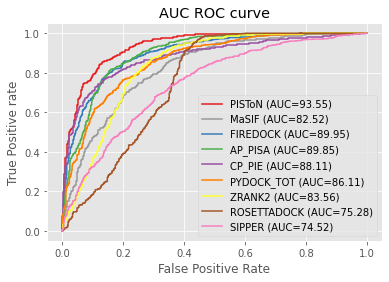

In [19]:
import torch.nn.functional as F
from sklearn import metrics

pred_probabilities = output.cpu().detach().numpy()

# Select probability of the complex to be positive (y=1)
#pred_probabilities = [float(x[1]) for x in pred_probabilities]

auc = metrics.roc_auc_score(true_label, pred_probabilities)
print(f"Final test AUC of {MODEL_NAME} with FireDock energy terms: {auc}")

import pandas as pd
## Save the file with all scores
all_ppis = masif_processed_pos_list + masif_processed_neg_list
out_file = f"{MODEL_DIR}/{MODEL_NAME}_scores.csv"
with open(out_file, 'w') as out:
    out.write("PPI,score,label\n")
    for i in range(len(pred_probabilities)):
        out.write(f"{all_ppis[i]},{pred_probabilities[i]},{true_label[i]}\n")
transsbind_df = pd.read_csv(out_file)

### other scores
import pandas as pd

SCORES_MASIF="../data/masif_test/MaSIF-Search_scores.csv"
OTHER_SCORES="../data/masif_test/Other_tools_SCORES.csv"

scores_masif = pd.read_csv(SCORES_MASIF)
scores_other = pd.read_csv(OTHER_SCORES)

def plot_ROC(df, score_name, label_name, model_name, ax, color, pos_label):
    fpr, tpr, thresh = roc_curve(df[label_name], df[score_name], pos_label=pos_label)
    if not pos_label:
        labels = -df[label_name] + 1
    else:
        labels=df[label_name]
    ROC = roc_auc_score(labels, df[score_name])
    ax.plot(fpr, tpr, linestyle='-',color=color, label=f'{model_name} (AUC={int(ROC*10000)/100})')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

colors = matplotlib.cm.Set1(range(9))


fig, ax = plt.subplots()
plot_ROC(transsbind_df, 'score', 'label', 'PISToN', ax, colors[0], pos_label=0)
plot_ROC(scores_masif, 'score', 'label', 'MaSIF', ax, colors[8], pos_label=0)

other_labels = ['FIREDOCK', 'AP_PISA', 'CP_PIE', 'PYDOCK_TOT', 'ZRANK2', 'ROSETTADOCK', 'SIPPER']
pos_labels = [0,0,1,0,0,0,1]
colors_array = ['r', 'c', 'm', 'y', 'black', 'orange', 'tan']
for i in range(len(other_labels)):
    plot_ROC(scores_other, other_labels[i], 'Label', other_labels[i], ax, colors[i+1], pos_label=pos_labels[i])



# # title
plt.title('AUC ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(f'out_AUC_{MODEL_NAME}.png',dpi=600)
plt.show();

In [20]:
##################
## SUCCESS RATE ##
##################

## Read HADDOCK models
CAPRI_LIST_FILE = '../data/lists/capri_list_models.txt'
CAPRI_DIR=os.getcwd()+'/../data/benchmark_deepRank/'

config = {}

DATA_DIR = os.getcwd()+'/../data/benchmark_deepRank/piston_prepare/'
config['dirs'] = {}
config['dirs']['data_prepare'] = DATA_DIR
config['dirs']['grid'] = config['dirs']['data_prepare'] + '07-grid/'
config['ppi_const'] = {}
config['ppi_const']['patch_r'] = 16 # 16



capri_list = [x.strip('\n') for x in open(CAPRI_LIST_FILE, 'r').readlines()]
test_list_updated = get_processed(capri_list, config)

print(f"{len(test_list_updated)}/{len(capri_list)} complexes were processed.")
unprocessed_complexes = set(capri_list) - set(test_list_updated)

print(f"Unprocessed complexes: {unprocessed_complexes}")
print("The PISToN score for those complexes will be assigned to 0.")

unique_pids = list(set([x.split('-')[0] for x in capri_list]))
print(unique_pids)

def read_score_dict(data_dir, score_file_affix, unique_pids, print_labels=False):
    score_dict = {}
    for pid in unique_pids:
        score_file = f"{data_dir}/{pid}/{pid}.{score_file_affix}"
        all_scores = []
        for line in open(score_file).readlines():
            curr_model, score = line.strip('\n').split('\t')
            model_id = curr_model.split('_')[0] + '-' + curr_model.split('_')[1]
            score = float(score)
            score_dict[model_id] = score
            all_scores.append(score)
        if print_labels:
            print(f"Sample {pid}: {int(np.sum(all_scores))} positives out of {len(all_scores)} models")
    return score_dict
            

labels_dict = read_score_dict(CAPRI_DIR, 'label', unique_pids, print_labels=True) 

# assign integer label
for key_i in labels_dict.keys():
    labels_dict[key_i] = int(labels_dict[key_i])
    
# Create labels array
labels = []
for ppi in test_list_updated:
    model_id = ppi.split('_')[0]
    labels.append(labels_dict[model_id])
    
print(f"Total {np.sum(labels)} positive complexes out of {len(labels)}")

from torch.utils.data import Dataset

class PISToN_dataset(Dataset):
    def __init__(self, grid_dir, ppi_list):

        ### Empirically learned mean and standard deviations:
        mean_array = [0.06383528408485302, 0.043833505848899605, -0.08456032982438057, 0.007828608135306595,
                      -0.06060602411612203, 0.06383528408485302, 0.043833505848899605, -0.08456032982438057,
                      0.007828608135306595, -0.06060602411612203, 11.390402735801011, 0.1496338245579665,
                      0.1496338245579665]
        std_array = [0.4507792893174703, 0.14148081793902434, 0.16581325050002976, 0.28599861830017204,
                     0.6102229371168204, 0.4507792893174703, 0.14148081793902434, 0.16581325050002976,
                     0.28599861830017204, 0.6102229371168204, 7.265311558033949, 0.18003612950610695,
                     0.18003612950610695]

        all_energies_mean = [-193.1392953586498, -101.97838818565408, 264.2099535864983, -17.27086075949363,
                             16.329959915611877, -102.78101054852341, 36.531006329113836, -27.1124789029536,
                             16.632626582278455, -8.784924050632918, -6.206329113924051, -1.8290084388185655,
                             -11.827215189873417]
        all_energies_std = [309.23521244706757, 66.75799437657368, 9792.783784373369, 25.384427268309658,
                            7.929941961525389, 94.05055841984323, 47.22518557457095, 24.392679889433445,
                            17.57399925906454, 7.041949880295568, 6.99554122803362, 2.557571754303165,
                            13.666329541281653]

        all_grids = []
        all_energies = []

        for ppi in ppi_list:
            grid = np.load(f"{grid_dir}/{ppi}.npy", allow_pickle=True)
            all_grids.append(grid)
            energies_path = f"{grid_dir}/refined-out-{ppi}.ref"
            energies = read_energies(energies_path, assign_zeros=True)
            all_energies.append(energies)

        background_mask = learn_background_mask(grid)

        grid = np.stack(all_grids, axis=0)
        grid = np.swapaxes(grid, -1, 1).astype(np.float32)
        all_energies = np.stack(all_energies, axis=0)

        print(f"Interaction maps shape: {grid.shape}")
        print(f"All energies shape: {all_energies.shape}")

        ### Standard scaling

        # Interactino maps:
        for feature_i in range(grid.shape[1]):
            grid[:, feature_i, :, :] = (grid[:, feature_i, :, :] - mean_array[feature_i]) / std_array[feature_i]
            # Mask out values that are out of the radius:
            grid = np.logical_and(grid, background_mask) * grid

        ## ENERGIES:
        for energy_i in range(all_energies.shape[1]):
            all_energies[:, energy_i] = (all_energies[:, energy_i] - all_energies_mean[energy_i]) / all_energies_std[
                energy_i]

        self.grid = grid
        self.all_energies = all_energies

    def __len__(self):
        return self.grid.shape[0]

    def __getitem__(self, idx):
        return self.grid[idx], self.all_energies[idx]
    
from torch.utils.data import DataLoader

capri_dataset = PISToN_dataset(config['dirs']['grid'], test_list_updated)

capri_loader = DataLoader(capri_dataset, batch_size=128, shuffle=False, pin_memory=False)

from tqdm import tqdm
device=torch.device("cuda")

# Infer in batches
all_outputs = []
with torch.no_grad():
    for grid, all_energies in tqdm(capri_loader):
        grid = grid.to(device)
        all_energies = all_energies.float().to(device)
        model = model.to(device)
        output, attn = model(grid, all_energies)
        all_outputs.append(output)
output = torch.cat(all_outputs, axis=0)
output

16581/16585 complexes were processed.
Unprocessed complexes: {'T37-1239_A_B', 'T37-401_A_B', 'T37-515_A_B', 'T37-919_A_B'}
The PISToN score for those complexes will be assigned to 0.
['T47', 'T32', 'T35', 'T30', 'T39', 'T40', 'T37', 'T41', 'T29', 'T46', 'T53', 'T54', 'T50']
Sample T47: 608 positives out of 1015 models
Sample T32: 15 positives out of 599 models
Sample T35: 3 positives out of 497 models
Sample T30: 2 positives out of 1096 models
Sample T39: 4 positives out of 1287 models
Sample T40: 535 positives out of 1971 models
Sample T37: 97 positives out of 1364 models
Sample T41: 347 positives out of 1096 models
Sample T29: 166 positives out of 1979 models
Sample T46: 24 positives out of 1570 models
Sample T53: 122 positives out of 1360 models
Sample T54: 19 positives out of 1304 models
Sample T50: 133 positives out of 1447 models
Total 2075 positive complexes out of 16581
Interaction maps shape: (16581, 13, 32, 32)
All energies shape: (16581, 13)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 17.26it/s]


tensor([ 0.2456,  0.9261,  1.9602,  ...,  0.2290, -0.6003,  0.7949],
       device='cuda:0')

In [30]:
import torch.nn.functional as F
from sklearn import metrics

# pred_probabilities = F.softmax(output, dim=1)
pred_probabilities = list(output.cpu().detach().numpy())

# Select probability of the complex to be positive (y=1)
#pred_probabilities = [float(x[1]) for x in output]

# append unprocessed complexes
pred_probabilities = pred_probabilities + [1 for x in list(unprocessed_complexes)]
all_capri_complexes = test_list_updated + list(unprocessed_complexes)
true_labels = labels + [labels_dict[x.split('_')[0]] for x in list(unprocessed_complexes)]

auc = metrics.roc_auc_score(true_labels, pred_probabilities)
print(f"Final test AUC for CAPRI dataset of {MODEL_NAME}: {1-auc}")

# other scores

dove_dict = read_score_dict(CAPRI_DIR, 'dove', unique_pids) 
deeprank_dict = read_score_dict(CAPRI_DIR, 'deeprank', unique_pids) 
haddockScore_dict = read_score_dict(CAPRI_DIR, 'haddockScore', unique_pids) 
iScore_dict = read_score_dict(CAPRI_DIR, 'iScore', unique_pids) 

def assign_score(score_dict, all_capri_complexes):
    score = []
    for ppi in all_capri_complexes:
        model_id = ppi.split('_')[0]
        score.append(score_dict[model_id])
    return score
        
dove_scores = assign_score(dove_dict, all_capri_complexes)
deeprank_scores = assign_score(deeprank_dict, all_capri_complexes)
haddockScore_scores = assign_score(haddockScore_dict, all_capri_complexes)
iScore_scores = assign_score(iScore_dict, all_capri_complexes)

auc = metrics.roc_auc_score(true_labels, dove_scores)
print(f"DOVE AUC for CAPRI dataset: {auc}")

auc = metrics.roc_auc_score(true_labels, deeprank_scores)
print(f"DeepRank AUC for CAPRI dataset: {1-auc}")

auc = metrics.roc_auc_score(true_labels, haddockScore_scores)
print(f"HADDOCK AUC for CAPRI dataset: {1-auc}")

auc = metrics.roc_auc_score(true_labels, iScore_scores)
print(f"iSCORE AUC for CAPRI dataset: {1-auc}")

capri_dict = read_score_dict(CAPRI_DIR, 'capri', unique_pids) 
capri_labels = assign_score(capri_dict, all_capri_complexes)

import pandas as pd

df = {"PISToN":pred_probabilities, 
      "DOVE": dove_scores, 
      "DeepRank": deeprank_scores, 
      "iSCORE": iScore_scores, 
      "HADDOCK": haddockScore_scores,
      "label": true_labels,
      "capri_quality": capri_labels,
     "model_name": all_capri_complexes,
     #"target": 
     }

df = pd.DataFrame(df)
df['target'] = df['model_name'].apply(lambda x: x.split('-')[0])
df

Final test AUC for CAPRI dataset of 3_PiSTON_SupCon_MARGIN:0;temp:0.5: 0.8126360382951516
DOVE AUC for CAPRI dataset: 0.5638840517134008
DeepRank AUC for CAPRI dataset: 0.7222781131417468
HADDOCK AUC for CAPRI dataset: 0.703525761211628
iSCORE AUC for CAPRI dataset: 0.7351248578047545


,PISToN,DOVE,DeepRank,iSCORE,HADDOCK,label,capri_quality,model_name,target
0,0.245601,0.0031,0.093072,-0.453,-66.65310,0,4.0,T29-0_A_B,T29
1,0.926115,0.2474,0.242705,-0.568,-65.60780,0,4.0,T29-1000_A_B,T29
2,1.960213,0.0617,0.992702,0.116,-76.41506,0,4.0,T29-1001_A_B,T29
3,1.523465,0.0062,0.154322,-0.292,9.46515,0,4.0,T29-1002_A_B,T29
4,1.959803,0.0125,0.992147,-0.680,-50.94296,0,4.0,T29-1003_A_B,T29
...,...,...,...,...,...,...,...,...,...
16580,0.794902,0.0453,1.000000,0.339,242.38618,0,4.0,T54-9_A_B,T54
16581,1.000000,0.1457,0.972651,-0.808,-59.38579,0,4.0,T37-1239_A_B,T37
16582,1.000000,0.1598,1.000000,0.966,854.35735,0,4.0,T37-401_A_B,T37
16583,1.000000,0.0068,0.999997,-0.436,697.20496,0,4.0,T37-515_A_B,T37


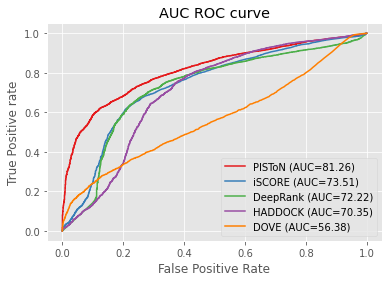

In [31]:
def plot_ROC(df, score_name, label_name, model_name, ax, color, pos_label):
    fpr, tpr, thresh = roc_curve(df[label_name], df[score_name], pos_label=pos_label)
    if not pos_label:
        labels = -df[label_name] + 1
    else:
        labels=df[label_name]
    ROC = roc_auc_score(labels, df[score_name])
    ax.plot(fpr, tpr, linestyle='-',color=color, label=f'{model_name} (AUC={int(ROC*10000)/100})')

    # matplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

colors = matplotlib.cm.Set1(range(9))

fig, ax = plt.subplots()

other_labels = ['PISToN', 'iSCORE', 'DeepRank', 'HADDOCK', 'DOVE']
pos_labels = [0,0,0,0,1]
colors_array = ['r', 'c', 'm', 'y', 'black']
for i in range(len(other_labels)):
    plot_ROC(df, other_labels[i], 'label', other_labels[i], ax, colors[i], pos_label=pos_labels[i])



# # title
plt.title('AUC ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(f'AUC_CAPRI_{MODEL_NAME}.png',dpi=600)
plt.show();

PISToN
[38, 38, 46, 69, 76, 76, 100]
HADDOCK
[23, 23, 23, 46, 53, 69, 76]
DeepRank
[15, 30, 30, 53, 61, 69, 92]
iSCORE
[38, 46, 46, 53, 61, 76, 84]
DOVE
[0, 15, 15, 15, 46, 46, 69]


,0,1,2,3,4,5,6,7
0,PISToN,38,38,46,69,76,76,100
1,HADDOCK,23,23,23,46,53,69,76
2,DeepRank,15,30,30,53,61,69,92
3,iSCORE,38,46,46,53,61,76,84
4,DOVE,0,15,15,15,46,46,69


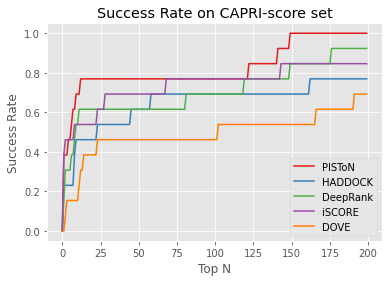

In [32]:
import numpy as np

all_targets = list(df['target'].unique())

def compute_success_rate(method, ascending, ax, color):
    hits_target = np.zeros(200)
    for target in all_targets:
        target_df = df[df['target']==target]
        target_df = target_df.sort_values(by=method, ascending=ascending).reset_index(drop=True)
        for i in range(1, 200):
            if 1 in list(target_df[:i]['label']):
                for j in range(i, 200):
                    hits_target[j] += 1/len(all_targets)
                break
    ax.plot(range(200), hits_target, linestyle='-',color=color, label=f'{method}')
    return hits_target

colors = matplotlib.cm.Set1(range(9))

fig, ax = plt.subplots()

compute_success_rate('PISToN', True, ax, colors[0])

methods = ['HADDOCK', 'DeepRank', 'iSCORE', 'DOVE']

for i,method in enumerate(methods):
    compute_success_rate(method, True, ax, colors[i+1])
            
 # # title
plt.title('Success Rate on CAPRI-score set')
# x label
plt.xlabel('Top N')
# y label
plt.ylabel('Success Rate')

plt.legend(loc='best')           
plt.savefig(f'HIT_RATE_{MODEL_NAME}.png',dpi=600)


def compute_success_rate(method, ascending):
    top1 = 0
    top3 = 0
    top5=0
    top10 = 0
    top25 = 0
    top100= 0
    top200 = 0
    for target in all_targets:
        target_df = df[df['target']==target]
        target_df = target_df.sort_values(by=method, ascending=ascending).reset_index(drop=True)
        if 1 in list(target_df[:1]['label']):
             top1+=1
        if 1 in list(target_df[:3]['label']):
             top3+=1
        if 1 in list(target_df[:5]['label']):
             top5+=1
        if 1 in list(target_df[:10]['label']):
            top10+=1
        if 1 in list(target_df[:25]['label']):
            top25+=1
        if 1 in list(target_df[:100]['label']):
             top100+=1
        if 1 in list(target_df[:200]['label']):
            top200+=1
    all_success_rate = [top1,top3, top5, top10, top25, top100, top200]
    #all_success_rate = [top10, top25, top200]

    all_success_rate = [int(x*100/len(all_targets)) for x in all_success_rate]
    print(method)
    print(all_success_rate)
    #print(f"Top1: {all_success_rate[0]} Top10: {all_success_rate[1]}; Top25: {all_success_rate[[2]]}; Top100: {all_success_rate[3]}; Top200: {all_success_rate[4]}")
    return all_success_rate


#compute_success_rate('PISToN', True)
methods = ['PISToN', 'HADDOCK', 'DeepRank', 'iSCORE', 'DOVE']
all_scores = []
for method in methods:
    all_scores.append([method]+compute_success_rate(method, True))

df = pd.DataFrame(all_scores)
df
